In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as trans
import torchvision as tv

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.linalg as LN

import os,time,random
os.sys.path.insert(0,'../')
import utils
import models
import attacks

In [161]:
batch_size=200
model_path = '../pretrains/store/resnet8-cifar10-87.25.pkl'
model_arch = 'resnet8'
B    = 2.0/255
step = 1
eps  = 2.0/255

train_set = dsets.CIFAR10(root='/home/leiwu/data/cifar10/',train=True,transform=trans.ToTensor(),download=True)
test_set  = dsets.CIFAR10(root='/home/leiwu/data/cifar10/',train=False,transform=trans.ToTensor(),download=False)
trX,trY   = torch.from_numpy(train_set.train_data.copy()).float()/255.0,torch.LongTensor(train_set.train_labels)
teX, teY  = torch.from_numpy(test_set.test_data.copy()).float()/255.0,   torch.LongTensor(test_set.test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size,shuffle=False)

model       = models.__dict__[model_arch]().cuda()
model_state = torch.load(model_path)
model.load_state_dict(model_state)
ct    = nn.CrossEntropyLoss().cuda()

def show(img,nrow=8):
    if isinstance(img,np.ndarray):
        img = torch.from_numpy(img)
    img = tv.utils.make_grid(img,nrow=nrow)
    npimg = img.numpy()
    npimg = np.transpose(npimg,(1,2,0))
    print(npimg.shape)
    plt.imshow(npimg,interpolation='nearest')
    plt.axis('off')

def batch_attack(model,ct,lr,eps,niter=1):
    adv_img = torch.zeros(10000,3,32,32)

    for i,(x,y) in enumerate(test_loader):
        if niter==1:
            lr = eps
        adv_x = attacks.gsm(model,ct,x.cuda(),y.cuda(),lr=lr,eps=eps,niter=niter)
        adv_img[i*batch_size:(i+1)*batch_size] = adv_x
    return adv_img

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
resnet: depth: 8, # of blocks at each stage: 1


In [162]:
adv_x = batch_attack(model,ct,lr=B,eps=eps,niter=step)
adv_pred = utils.predictor(model,adv_x.cuda())
clean_pred = utils.predictor(model,teX.cuda())
correct  = adv_pred.eq(clean_pred)
wrong    = torch.ones(10000).byte()-correct
wrong_idx = wrong.nonzero()

(102, 102, 3)
(102, 102, 3)
pred:->    dog    cat    cat    cat    cat  plane    dog    dog    dog
truth:-> horse    dog   deer  truck  horse  horse   bird    cat    cat


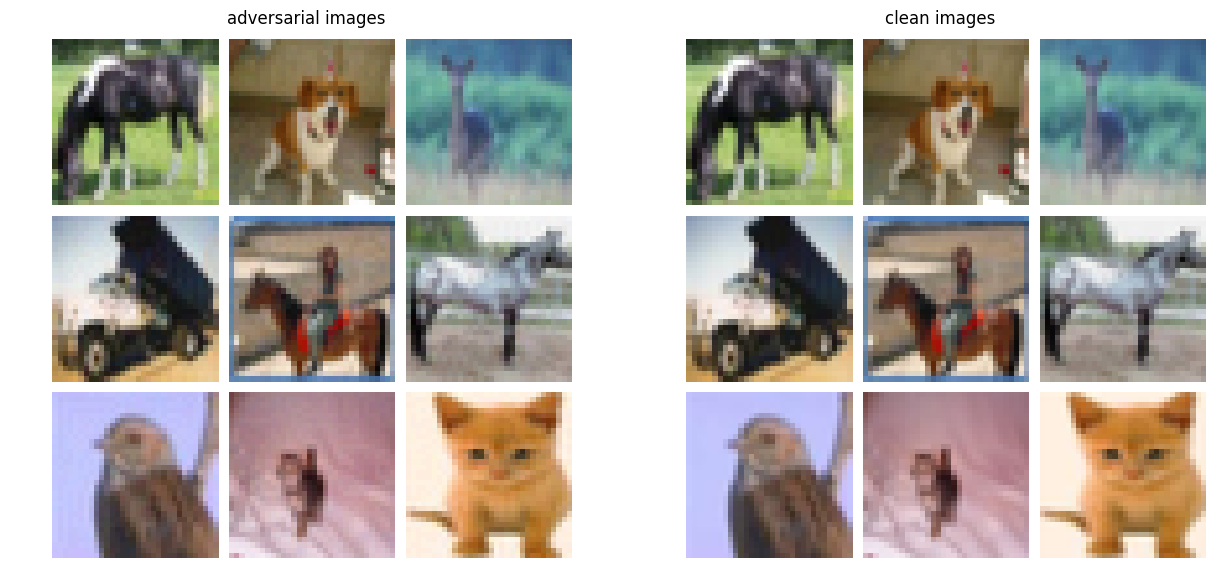

In [189]:
wrong_idx = wrong.nonzero().squeeze()
adv_x_wrong    = adv_x.index_select(0,wrong_idx)
clean_x_wrong  = teX.index_select(0,wrong_idx)
adv_pred_wrong = adv_pred.index_select(0,wrong_idx)
clean_pred_wrong = clean_pred.index_select(0,wrong_idx)
s,d = 2000,9
plt.figure(figsize=(15,30))
plt.subplot(1,2,1);   show(adv_x_wrong[s:d+s],nrow=3);   plt.title('adversarial images')
plt.subplot(1,2,2);   show(clean_x_wrong[s:d+s],nrow=3); plt.title('clean images')

print('pred:->  ' +  '  '.join('%5s'%(classes[j]) for j in adv_pred_wrong[s:d+s]))
print('truth:-> ' +  '  '.join('%5s'%(classes[j]) for j in clean_pred_wrong[s:d+s]))